<a href="https://colab.research.google.com/github/johannes-kk/am207/blob/master/exercises/01_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAY 1: Regression


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: September 3rd, 11:59pm EST

**Names of Group Members**: Alfred Wahlforss, Nima Farrokhsiar, Maggie Wang, Johannes Kolberg, Raphael Pellegrin, Connor Capitolo, Rohit Beri

alfredwahlforss@g.harvard.edu, connorcapitolo@g.harvard.edu    
mof796@g.harvard.edu (Nima Farrokhsiar)

Does anyone want to continue working on this?

NF: I am avilable 5-7PM EST this evening.

CC: I'm available after 4:30pm EST today.

RP: I am avalaible 5-7 PM EST.


## Learning Goals:

1. become familiar with using `sklearn` and `numpy` for Linear and Bayesian Linear Regression
2. explore the difference between probabilistic and non-probabilistic models for linear regression
3. learn how to interpret and evaluate probabilistic models
4. explore the difference between Bayesian and non-Bayesian probabilistic models for linear regression
4. lean how to interpret and evaluate Bayesian models

In [ ]:
# import the necessary python libraries
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

### We include some auxiliary functions that we will need to use later.

In [ ]:
def generate_toy_data(n_points=20, noise_std=0.05):
    ''' Function to generate a toy dataset '''
    x = np.linspace(-5, 5, n_points)
    x_test = np.linspace(-5, 5, 50)

    #define a function relating input to output
    f = lambda x: 0.01 * x**3

    #generate noisy training labels
    y = f(x) + np.array([np.random.normal(0, noise_std * x_n**2) for x_n in x])
    y_test = f(x_test) + np.array([np.random.normal(0, noise_std * x_n**2) for x_n in x_test])
    
    return x, y, x_test, y_test

def get_posterior_samples(w0_prior_var, w1_prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
  ''' Function to generate samples from the posterior and posterior predictive of a Bayesian linear model '''
  #define the variances of the normal priors for w_0 and w_1
  #note that rather than treating the normal priors for w_0 and w_1 separately,
  #we can jointly express this prior as a bivariate normal distribution with a diagonal covariance matrix
  prior_variance = np.diag([w0_prior_var, w1_prior_var])
  #define the inverse of the prior variance, this is called the precision
  prior_precision = np.linalg.inv(prior_variance)

  #this 'epsilon' offsett is sometimes needed to ensure numerical stability of the matrix inverse operation
  epsilon = 1e-5

  #compute the posterior precision matrix
  posterior_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
  #invert the precision matrix to get the posterior covariance matrix
  posterior_variance = np.linalg.inv(posterior_precision + epsilon * np.ones(x_matrix.shape[1])) 
  #compute hte posterior mean
  posterior_mean = posterior_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

  #sampling 100 points from the posterior distribution over w_0 and w_1
  posterior_samples = np.random.multivariate_normal(posterior_mean.flatten(), posterior_variance, size=samples)

  #take posterior predictive samples
  posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
  posterior_predictive_samples = posterior_predictions[np.newaxis, :, :] + np.random.normal(0, noise_var**0.5, size=(100, posterior_predictions.shape[0], posterior_predictions.shape[1]))
  posterior_predictive_samples = posterior_predictive_samples.reshape((100 * posterior_predictions.shape[0], posterior_predictions.shape[1]))

  return posterior_samples, posterior_predictions, posterior_predictive_samples

## 1. Non-Probabilistic Models: Choosing a Loss Function 
In this problem, you are going to explore the difference between the different possible loss functions for fitting a linear model to a data set.

1. **(Max absolute deviation)** Count only the biggest "error"
$$
\max_n |y_n - \hat{y}_n| 
$$
2. **(Sum of absolute deviations)** Add up all the "errors"
$$
\sum_n |y_n - \hat{y}_n| 
$$
3. **(Sum of squared errors)** Add up the squares of the "errors"
$$
\sum_n |y_n - \hat{y}_n|^2 
$$
4. **(Mean squared error)** We can also average the squared "errors".
$$
\frac{1}{N}\sum_{n=1}^N |y_n - \hat{y}_n|^2 
$$

Again, $y_n$ is the observed target, $\hat{y}_n$ is the predicted target.

Fitting a linear model 
$$
y = w_1x + w_0
$$
to the data using one of these loss functions is a non-probablistic approach, since our model does not explicitly model the observation noise. Note that the choice of the mean squared error implies a probabilistic model (this is something you'll explore in HW0).

**Exercise 1:** Describe one real-life application wherein it would be more appropriate to use max absolute deviation rather than mean squared error.

***Answer:*** Quality Control, Conditional monitoring of equipment

**Exercise 2:** Describe one real-life application wherein it would be more appropriate to use sum of squared errors rather than max absolute deviation.

***Answer:*** Take into account all errors (prioritize bigger errors due to the square) + easier to take derivative. Examples: prediction

**Exercise 3:** Describe why it might be more preferable to use mean squared error rather than sum of squared errors.

***Answer:*** 
SSE is additive and will continue to grow with the data. MSE will not.
In batch stochastic gradient descent SSE will penalise large deviations heavily at the cost of average performance, whereas MSE will be more lenient on few large deviations in favour of more accurate across the board.

**Exercise 4:** Describe qualitatively the difference between penalizing sum of absolute deviations and sum of squared errors. 

SSE is additive and will continue to grow with the data. MSE will not. In batch stochastic gradient descent SSE will penalise large deviations heavily at the cost of average performance, whereas MSE will be more lenient on few large deviations in favour of more accurate across the board.

***Hint:*** think about which kinds of errors are heavily penalized under each loss function and which kinds of errors are 'tolerated' by each loss function.

---

## 2. Probabilistic Models: Linear Regression

In this problem, you are given a dataset with a single predictor $X$ and a single outcome $y$, and your task is to fit a linear model to the data. 

Assume that the outcome $y$ can be modeled by the following **probabilistic** or **statistical** model (so called because we explicitly model the observation noise $\epsilon$):
\begin{aligned}
y &= f(x) + \epsilon = w_1x + w_0 + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5)
\end{aligned}
where $w_1$ and $w_0$, the *parameters* of the function $f$, are unknown constants. 

We learn the maximum likelihood estimates of the slope $w_1$ and the intercept $w_0$ (using `sklearn`), and visualize the resulting MLE linear model.


In [ ]:
# Step 0. generate a data set for doing regression
x_train, y_train, x_test, y_test = generate_toy_data(n_points=200) 

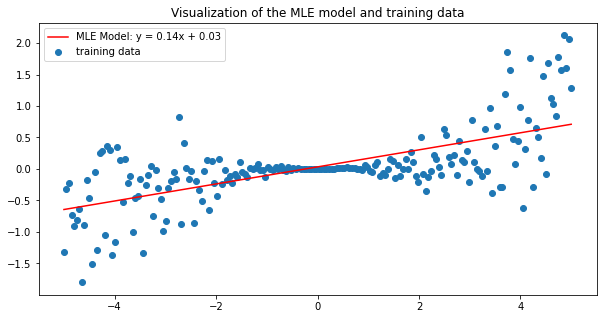

In [ ]:
# Step 1. Instantiate an Linear Regression model object
linear_regressor = LinearRegression()
# Step 2. Fit model to the training data
linear_regressor.fit(x_train.reshape(-1,1),y_train.reshape(-1,1))
# Step 3. Make predictions on training data 
y_train_pred = linear_regressor.predict(x_train.reshape(-1,1))

# Step 4. Extract the MLE for slope
slope_mle = np.round(linear_regressor.coef_[0][0], 2)
# Step 5. Extract the MLE for intercept
intercept_mle = np.round(linear_regressor.intercept_[0], 2)

# Step 6. Visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5
ax.scatter(x_train, y_train, label='training data') # scatter plot the training data
ax.plot(x_train, y_train_pred, 'r', label='MLE Model: y = {}x + {}'.format(slope_mle, intercept_mle))  # plot the learned linear regression function by plotting the predictions
ax.set_title('Visualization of the MLE model and training data')
ax.legend(loc='best') # display legend
plt.show() # display the figure

**Exercise 5:** Compute the Mean Square Error (MSE) of your model on the training dataset and on the testing dataset.

Compute the residuals on the training data. Visualize these residuals in a histogram. 

In [ ]:
# Hint: you can use a pre-defined MSE function in the library documentation at: 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
#
## COMPLETE
y_test_pred = linear_regressor.predict(x_test.reshape(-1,1))
training_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
#
print('MSE on training data is: {}'.format(training_mse))
print('MSE on test data is: {}'.format(test_mse))

MSE on training data is: 0.2085048391956224
MSE on test data is: 0.2354246354569053


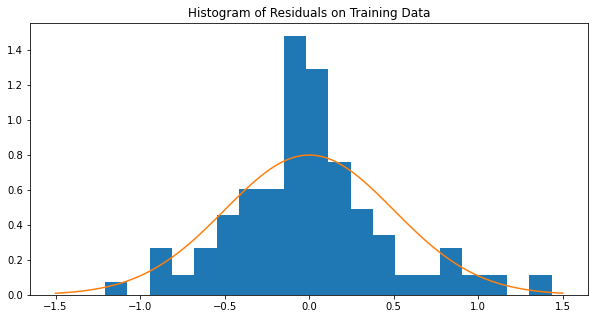

In [ ]:
## COMPLETE
import scipy.stats as stats

# Compute residuals
residuals = y_train - y_train_pred.reshape(-1,)
#
# Visualize residuals
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5
#
# see documentation for the '.hist()' plotting function here:
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html
ax.hist(residuals, bins=20, density=True)
mu = 0
variance = 0.25
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
#
ax.set_title('Histogram of Residuals on Training Data')
plt.show()

**Exercise 6:** Is a linear model appropriate for this data? Is our linear probabilistic model appropriate for this data? Why or why not? 

Based on your answer, suggest a way to improve our probabilistic model.

Support your answer using concepts you learned from lecture, the visualizations of the data and the model, the resicual, the MSE etc.

***Answer:*** 

A linear model does not seem appropriate to this data.

The histogram with a super-imposed normal distribution per the assumed parameters of the signal noise shows the model residuals are clearly not normally distributed, as assumed. The residuals have higher kurtosis and longer tails, which suggests the model fits portion(s) of the data accurately but has areas where it's missing a lot more than it should. This usually occurs outside the mass of the data, as we indeed see in the plot of the MLE line versus the data scatter plot.

The MSE is also far higher on test than on train. Though not unusual, this large of a difference suggests the fit does not generalise well. This in turn suggests we have imposed an ill-suited functional form for the model.


**Exercise 7:** Based on your explorations, compare the paradigms of non-probabilistic and probablistic modeling. What are the pros and cons of each approach (what are the advantages of explicitly modeling the observation noise? when should we pick a loss function that does not arise from an explicit noise model?)? 

***Answer:***

For probabilistic modeling, we have the advantage of being able to investigate the assumptions of the model as they are explicit. In this case, we can dissect our assumed distribution of noise in the true data-generating process and compare this against the residuals of our model. If the model is accurate, its mistakes should reduce to (nearly) the unavoidable noise in the underlying data.

A downside is we introduce additional assumptions and hyperparameters that require tuning. It is also not well-suited to all problems. For instance, some use cases require fitting models that prioritise certain situations, such as minimizing large and costly mistakes (e.g. in price prediction you'd often prefer rarely being very wrong, and rather accept being a little more wrong most of the time).

---

## 3. Bayesian Models: Bayesian Linear Regression

In this problem, your task is to perform Bayesian linear regression on the same dataset as in Problem 2.

Assume that the outcome $y$ can be modeled by the following process:
\begin{aligned}
y &= f(x) + \epsilon = w_1x + w_0 + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5)\\
w_0 &\sim \mathcal{N}(0, 1)\\
w_1 &\sim \mathcal{N}(0, 0.5)
\end{aligned}
In this model, we assume the same likelihood as in Part I, but we also include priors for $w_0$ and $w_1$: $p(w_0) = \mathcal{N}(0, 1)$, $p(w_1) = \mathcal{N}(0, 0.5)$.

In HW0, you'll verify that the posterior over $w_1$ and $w_0$, jointly, is also a (multivariate) normal or **Gaussian** distribution:
$$p(w_1, w_0 | y_1, \ldots y_n, x_1, \ldots, x_n) = \mathcal{N}(\mu, \Sigma)$$
where $\Sigma = 
\left[\begin{matrix}
\sigma_{w_0}^2 & \rho\\
\rho & \sigma_{w_1}^2\\
\end{matrix}\right]$ and $\mu$ are determined by the prior variances, the observation noise variance and the data.

**Exercise 8:** Visualize samples from the posterior $p(w_1, w_0 | y_1, \ldots y_n, x_1, \ldots, x_n)$. Use this and your understanding of Gaussian distributions to ***very roughly*** estimate $\sigma_{w_0}^2, \sigma_{w_1}^2, \rho$. 

The quantities $\sigma_{w_0}^2, \sigma_{w_1}$ are often said to quantify the uncertainty we have about our estimate of $w_0$ and $w_1$. Why does this intuitively make sense? Given the visualization of the posterior samples which parameter are we more certain about?

**Answer:** $\sigma_{w_0}^2, \sigma_{w_1}$ each describe the spread of the data, so if either of the variables has a larger spread, then it makes sense that there is more uncertainty about our estimate. Likewise, if the variance is less spread out, meaning a smaller variance, then there is less uncertainty about the estimate. Given the visualization below, there is more uncertainty about $w_0$. $\rho$ (the correlation) tells us about the relation between $w_0$ and $w_1$ and they are related to the orientation/tilt of the axes of the ellipse. We tried trial and error to estimate the parameters $\sigma_{w_0}^2, \sigma_{w_1}$ and $\rho$ (see below).

Discuss what $\rho$ tells us about the relationship between $w_0$ and $w_1$ in the posterior. Why is it important to model $\rho$, instead of just $\sigma_{w_0}^2, \sigma_{w_1}$?

$\rho$ tells us about the relation between $w_0$ and $w_1$. There is interaction between $w_0$ and $w_1$ so if $\rho$ is not zero, infromation about one of $w_0$ or $w_1$ gives us some knowledge about the other.



In [ ]:
# Step 1: define the observation noise variance
noise_variance = 0.5
# Step 2: define the variance of the normal priors on w_0 and w_1
w0_prior_var = 1.
w1_prior_var = 0.5
# Step 3: define the number of samples to draw from the posterior
samples = 800
# Step 4: concatenate a column of 1's to the training data so that inference computations can be cast as matrix operations (this increases efficiency)
# we do this using the PolynomialFeatures model from sklearn
poly = PolynomialFeatures(1)
x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

# Step 5: get samples from the posterior distribution over w_0 and w_1
posterior_samples, posterior_predictions, posterior_predictive_samples = get_posterior_samples(w0_prior_var, w1_prior_var, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_train_poly, samples)

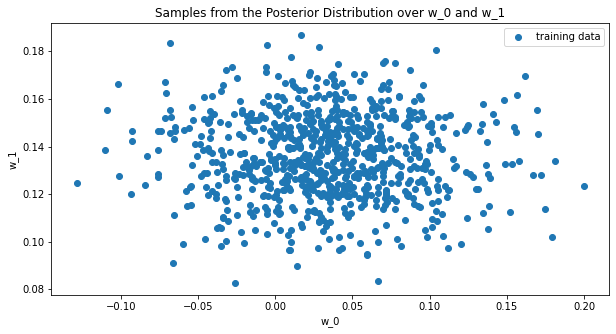

In [ ]:
# Step 6. Visualize the posterior samples
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5
ax.scatter(posterior_samples[:, 0], posterior_samples[:, 1], label='training data') # scatter plot the training data
ax.set_title('Samples from the Posterior Distribution over w_0 and w_1')
ax.legend(loc='best') # display legend
ax.set_xlabel('w_0') # set the x-axis label
ax.set_ylabel('w_1') # set the y-axis label
plt.show() # display the figure

This is for our understanding of $\Sigma

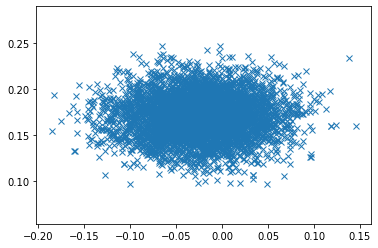

In [ ]:
#this is our trial and error estimate to understand covariance matrix

import numpy as np
import matplotlib.pyplot as plt
mean = [-0.025, 0.17]
cov = [[0.002, 0], [0, 0.0005]]
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [ ]:
def get_posterior_samples_2(w0_prior_var, w1_prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
  ''' Function to generate samples from the posterior and posterior predictive of a Bayesian linear model '''
  #define the variances of the normal priors for w_0 and w_1
  #note that rather than treating the normal priors for w_0 and w_1 separately,
  #we can jointly express this prior as a bivariate normal distribution with a diagonal covariance matrix
  prior_variance = np.diag([w0_prior_var, w1_prior_var])
  #define the inverse of the prior variance, this is called the precision
  prior_precision = np.linalg.inv(prior_variance)

  #this 'epsilon' offsett is sometimes needed to ensure numerical stability of the matrix inverse operation
  epsilon = 1e-5

  #compute the posterior precision matrix
  posterior_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
  #invert the precision matrix to get the posterior covariance matrix
  posterior_variance = np.linalg.inv(posterior_precision + epsilon * np.ones(x_matrix.shape[1])) 
  #compute hte posterior mean
  posterior_mean = posterior_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

  #sampling 100 points from the posterior distribution over w_0 and w_1
  posterior_samples = np.random.multivariate_normal(posterior_mean.flatten(), posterior_variance, size=samples)

  #take posterior predictive samples
  posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
  posterior_predictive_samples = posterior_predictions[np.newaxis, :, :] + np.random.normal(0, noise_var**0.5, size=(100, posterior_predictions.shape[0], posterior_predictions.shape[1]))
  posterior_predictive_samples = posterior_predictive_samples.reshape((100 * posterior_predictions.shape[0], posterior_predictions.shape[1]))

  return posterior_mean, posterior_variance

In [ ]:
true_mean, true_variance = get_posterior_samples_2(w0_prior_var, w1_prior_var, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_train_poly, samples)

In [ ]:
true_mean

array([[-0.0230904 ],
       [ 0.16820779]])

In [ ]:
true_variance

array([[ 2.49376552e-03, -7.40245855e-12],
       [-7.40245855e-12,  2.96838594e-04]])

**Answers:** So our trial and error estimation wasn't too far off.

In Bayesian linear regression, we obtain a distribution over possible parameters given the data, $p(w_1, w_0 | y, x)$, rather than a single ***point-estimate*** of the 'best' parameters. This means that when we predict an outcome for, say, $x=2$ we get a distribution over possible values of $y$ rather than a single $y$. The distribution over the predicted $y$ for a given $x$ is called the ***posterior predictive***, and is denoted $p(y|x)$

**Exercise 9:** Visualize the **95% posterior predictive interval** (this is the interval that includes 95% of the posterior predictive values) for the training data -- this is usually visualized as a shaded tube containing the 95% of the posterior predictive values for each test $x$-value. 

The width of the 95% posterior predictive interval is said to quantify the uncertainty of the Bayeisan model at each input $x$. Why is this reasonable?

***Answer:*** 95% of the posterior predictive values for each test $x$-value will be in the interval - so if the interval is smaller, there is less uncertainty about the model.

Compare the 95% posterior predictive interval of our model with the data, are our uncertainties sensible? Are they what you want them to be (you might interpret higher uncertainty at an $x$ to tell you that the model is less confident in it's prediction at $x$)?

In [ ]:
# Step 1: compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

# Step 2: compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

# Step 3: compute the 50 th percentile of the posterior predictive predictions
pp_mean = np.mean(posterior_predictive_samples, axis=0)

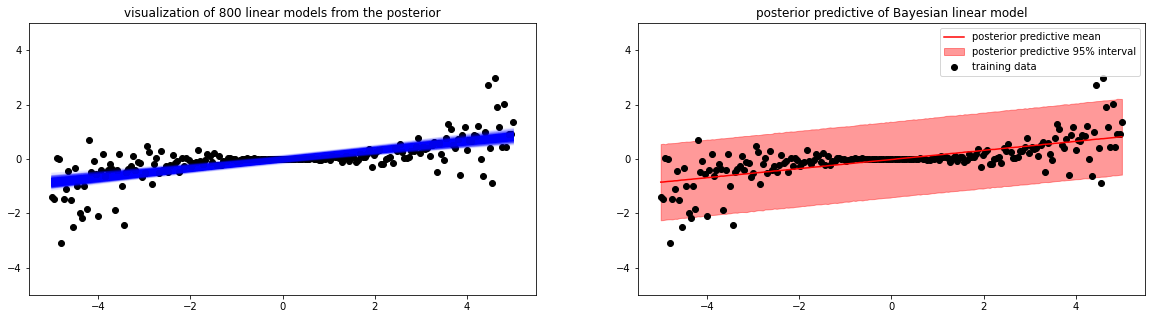

In [ ]:
# Step 4: Visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# visualize the training data 
ax[0].scatter(x_train, y_train, color='black', label='training data') 

# visualize each model from the posterior
for sample in posterior_predictions:
    ax[0].plot(x_train, sample, color='blue', alpha=0.05)

ax[0].set_ylim([-5, 5])
ax[0].set_title('visualization of {} linear models from the posterior'.format(samples))

# visualize the mean of the posterior predictive
ax[1].plot(x_train, pp_mean, color='red', label='posterior predictive mean')
# visualize the 95% posterior predictive interval
ax[1].fill_between(x_train, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior predictive 95% interval')
# visualize the training data
ax[1].scatter(x_train, y_train, color='black', label='training data')

ax[1].legend(loc='best')
ax[1].set_title('posterior predictive of Bayesian linear model')
ax[1].set_ylim([-5, 5])
plt.show()